#### author : Amine KHELDOUNI

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.neighbors import KNeighborsClassifier

## 1. Données : velib

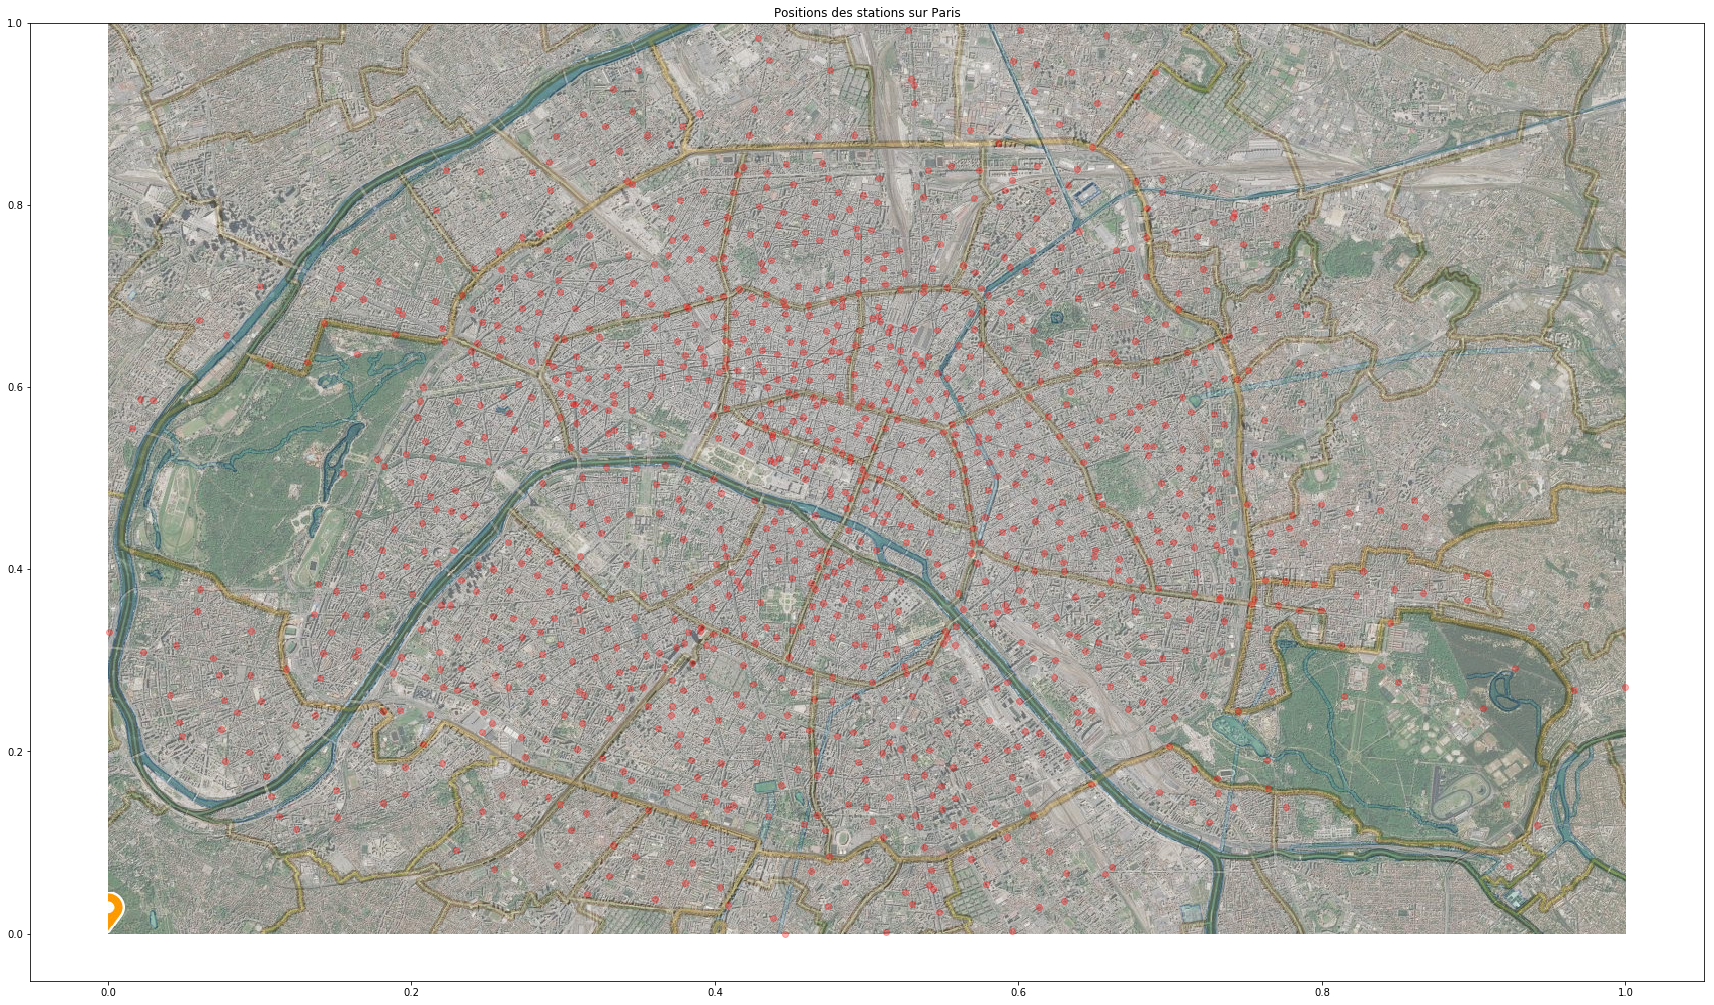

In [7]:
fname="velib-enpc.npz"
with  np.load(fname) as obj:
    # Dictionnaire des informations des stations idvelib->
    #(nom,adresse,x,y,nbre attaches,long,lat)
    stations = dict(obj['stations'].tolist())
    # Correspondance idvelib->ligne matrice
    stations_idx = dict(obj['stations_idx'].tolist())
    # Correspondance ligne matrice->idvelib
    idx_stations = dict(obj['idx_stations'].tolist())
    # Matrice du nombre de velos dispo par station par minute
    histo = obj['histo']

parismap = mpimg.imread("paris.png")

# Permet d'afficher la carte de Paris
def show_map():
    plt.imshow(parismap,extent=[0,1,0,1],aspect=0.6)

    
# Question 2.1
geo_data = np.array([ [x[2],x[3],x[4]] for x in stations.values()])
plt.figure(figsize=(30, 30))
show_map()
plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="red")
plt.title('Positions des stations sur Paris')
plt.draw()
plt.show()


## 2. Estimation de densité


### 2.1 Histogramme

Test de vérification des densités :  1.0


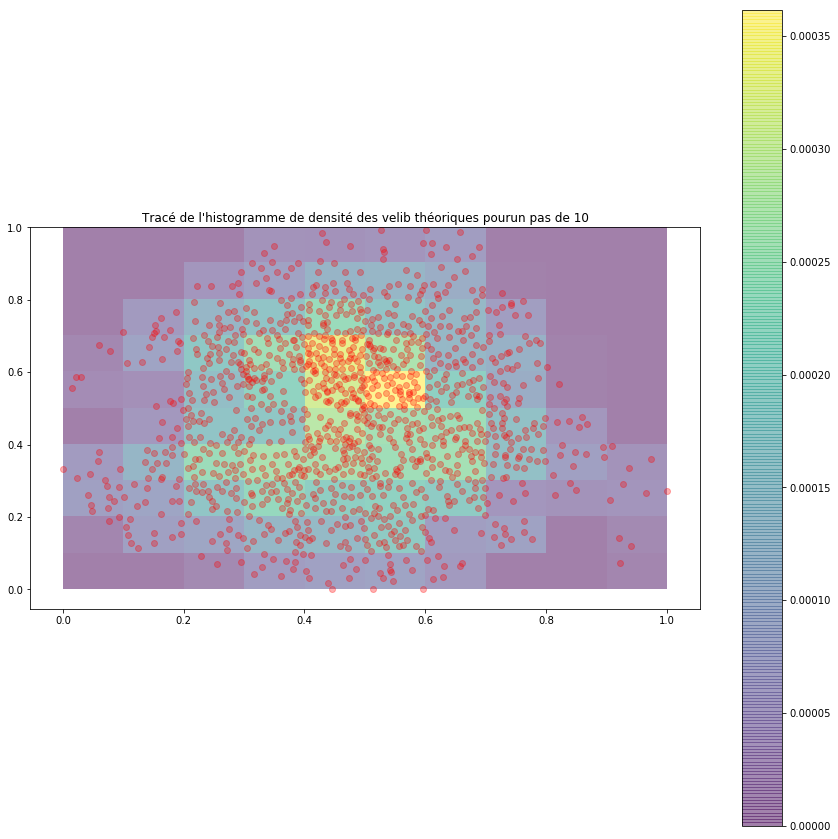

Test de vérification des densités :  1.0


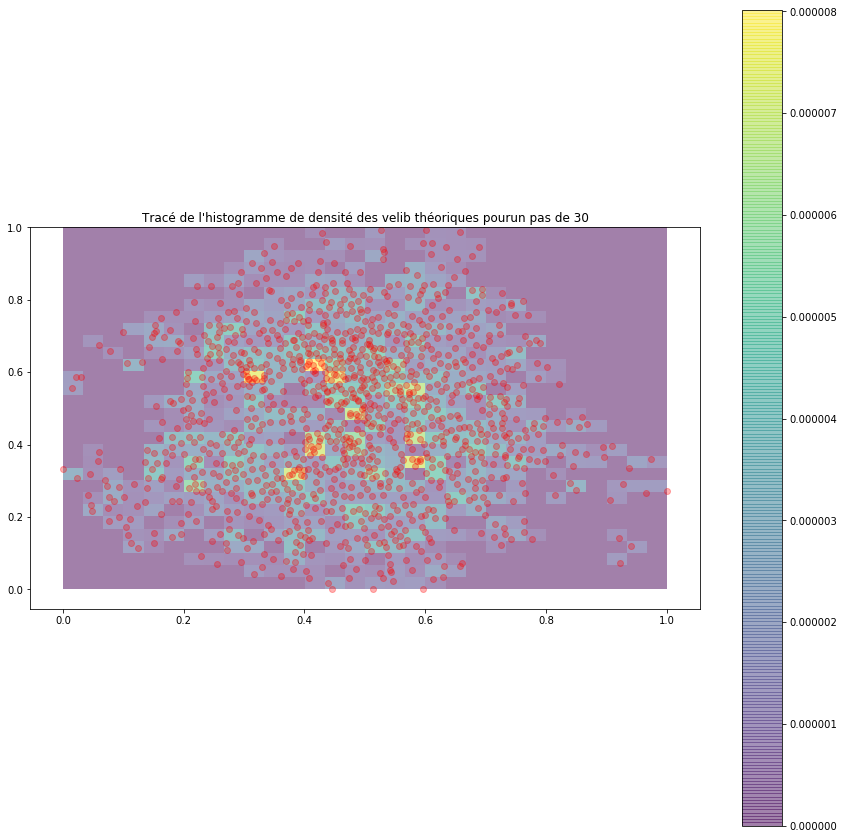

Test de vérification des densités :  1.0


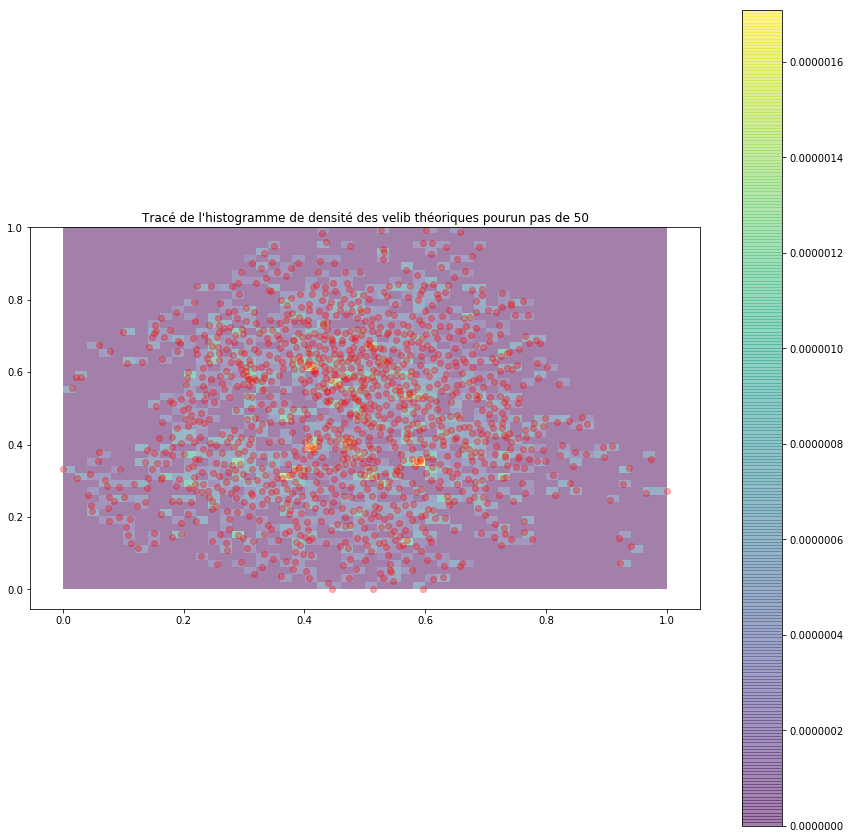

Test de vérification des densités :  1.0


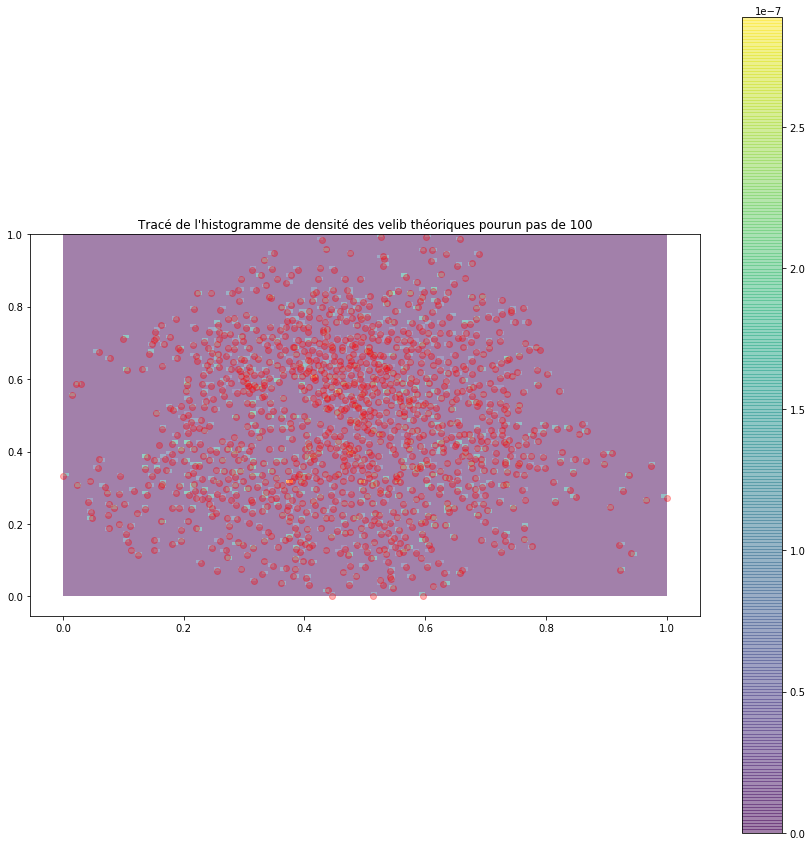

In [8]:
def gridHist(x, y, s):
    for k in range(s):
        if x >= k*1./s and x <= (k+1)*1./s:
            for j in range(s):
                if y >= j*1./s and y <= (j+1)*1./s:
                    return k, j


#### Constantes Histogramme
def histogram(STEPS):
    geo_exemple= np.zeros((STEPS, STEPS))
    resultat = geo_exemple

    for i in range(len(geo_data)):
        k, j = gridHist(geo_data[i][0], geo_data[i][1], STEPS)
        resultat[k, j] += geo_data[i,2] / (np.sum(geo_data[:,2])* STEPS**2)

    print("Test de vérification des densités : ", np.sum(resultat)*STEPS**2)
    plt.figure(figsize=(15, 15))
    plt.imshow(resultat.T,extent=[0,1,0,1],interpolation='none',alpha=0.5, \
               origin = "lower",aspect=0.6)
    plt.title("Tracé de l'histogramme de densité des velib théoriques pour"+\
              "un pas de "+str(STEPS))
    plt.colorbar()
    plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="red")
    plt.show()

histogram(10)
histogram(30)
histogram(50)
histogram(100)

On remarque que l'histogramme de densité augmente en valeur d'autant plus qu'on se rapproche du centre. 
En effet, la densité de velib théorique est plus grande au centre de Paris et la densité se rapproche plus de zéro vers les bords. Plus on raffine le maillage et la discrétisation, plus on gagne en précision car al répartition est plus raffinée et les stations sont prises plus ponctuellement. Mais à un certain seuil, la discrétisation ne servirait plus à rien car on prendrait chaque station toute seule dans son carré de discrétisation ce qui reviendrait à parcourir tout l'espace.


#### Q 2.3    
Pour de faibles pas de temps, on remarque qu'une grosse entité de discrétisation (carré du maillage) est considérée dense en velib théorique par rapport au d'autres portions de la carte. Pour des pas de discrétisation plus fins, le maillage est encore plus précis et les zones à forte densité sont surlignées plus séparemment sur la carte, bien que globalement au milieu de celle-ci.

Finalement, les résultats ne sont pas très stable car la méthode de l'histogramme est naïve face au bruit sur les données et donc le fait de décaler le positionnement d'une station d'un carré du maillage à l'autre fausse le résultat. 

Le modèle exposé ici prend on compte comme paramètres les poids des stations (velib théoriques associés) ainsi que l'hyperparamètre "pas de discrétisation" qui est le seul à être modifier. Si on augmente le nombre de dimension (ie. le nombre de données sur les stations), le nombre de poids augmentera avec le nombre de stations et finalement le pas de discrétisation devra être d'autant plus petit pour détailler un peu plus le modèle et la répartition des velib.

La méthode dite de l'histogramme présente donc finalement des avantages mais des inconvénients également.
En effet, elle est facile à implémenter car repose sur un concept de discrétisation naïf. Elle est relativement peu coûteuse car de complexité linéaire par rapport au nombre de données (en gardant un pas de discrétisation raisonnable et pas excessivement élevé). Mais d'un autre côté, elle présente des problèmes de stabilité dits effets de bord, elle manque également de précision comparée à d'autres méthodes que nous verrons dans la suite.


### 2.2 Fenêtres de Parzen

In [9]:
# Question 2.4

def uni(x, data, sigma):
    Xc = (x - data) / sigma
    K_tmp = abs(Xc) <= 0.5
    Ku = K_tmp.min(axis=1)
    return Ku

def gaussian(x, data, sigma):
    d = len(x)
    Xc = (x - data) / sigma
    Kg = np.exp(-0.5 * np.linalg.norm(Xc, axis=1)**2) / (2 * np.pi)**(d/2.)
    Kg = np.array(Kg).reshape((Kg.shape[0], 1))
    return np.array(Kg)

In [10]:
# Question 2.5

def parzen(x, data, weight, sigma, kernel):
    d = len(x)
    return (kernel(x, data, sigma).T).dot(weight) / (sigma**d * np.sum(weight))

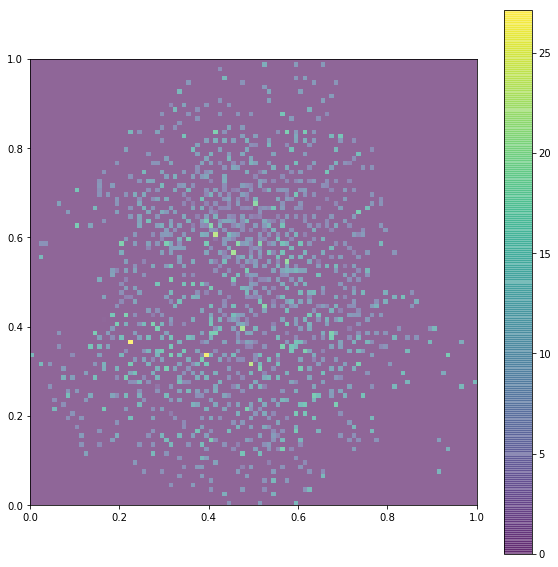

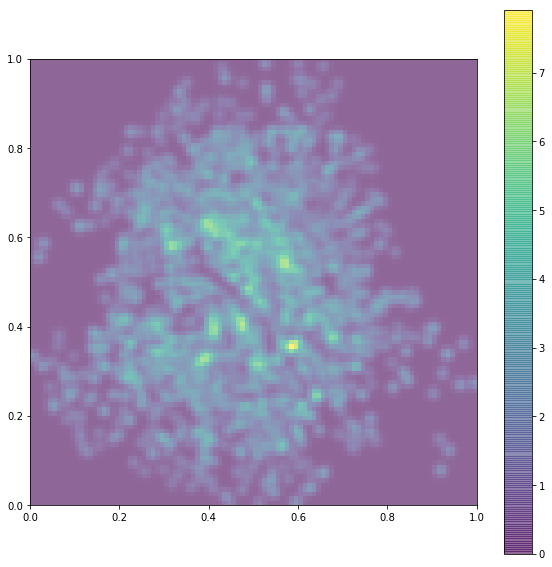

In [11]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
STEPS = 100
sigma = 0.01

xx,yy = np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
grid = np.c_[xx.ravel(),yy.ravel()]
plt.figure(figsize = (10, 10))
pdf = np.array([parzen(g, geo_data[:,:2], geo_data[:,2], sigma, uni) for g in grid])\
.reshape((STEPS,STEPS))
plt.imshow(pdf,extent = [0,1,0,1], interpolation='none', alpha=0.6, origin="lower")
plt.colorbar()


xx,yy = np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
grid = np.c_[xx.ravel(),yy.ravel()]
plt.figure(figsize = (10, 10))
pdf = np.array([parzen(g, geo_data[:,:2], geo_data[:,2], sigma, gaussian)\
                for g in grid]).reshape((STEPS,STEPS))
plt.imshow(pdf,extent = [0,1,0,1], interpolation='none', alpha=0.6, origin="lower")
plt.colorbar()
plt.show()
#plt.scatter(train_data[:,0],train_data[:,1],alpha=0.15,color="red")

#### Q 2.6
En partant d'un paramètre $\sigma = 1$, on remarque que globalement, la densité est forte au milieu de la carte. Ensuite, plus on baisse le paramètre $\sigma$, plus on affine le modèle et on remarque une répartition plus fidèle à la répartition du nuage de point (les stations). Pour un $\sigma$ qui tend vers 0, on obtient un modèle qui considère les stations ponctuellement. Il faut donc bien choisir un $\sigma$ suffisamment petit pour voir la réparation de la densité et pas trop petit pour ne pas réduire le problème à un schéma ponctuel des stations.

On remarque également que pour un $\sigma$ suffisamment petit, un noyau uniforme ne donne pas de résultats satisfaisants, contrairement au noyau gaussien continu, qui offre une discrétisation lisse de la réparatition de la densité.

#### Q 2.7
Les moindres carrés sont difficiles à appliquer pour évaluer l'estimation car nous n'avons pas de référence contre laquelle on pourrait confronter l'estimateur lors du calcul des densités.


In [12]:
threshold = int(0.7 * geo_data.shape[0])
def likelihood_estimator(data, weight, sigma, kernel):
    V = 0
    data_test = data[threshold:]
    data_train = data[:threshold]
    n = data.shape[0]
    for s in range(len(data_test)):
        V -= np.log(parzen(data_test[s], data_train, weight, sigma, kernel)+1e-10)
    return V

def compare_kernel(data, weight):
    plt.figure(figsize = (10, 10))
    sigma = np.linspace(0.01, 1, 100)
    uni_likelihood = []
    gaussian_likelihood = []
    for k in range(len(sigma)):
        uni_likelihood += [likelihood_estimator(data, weight, sigma[k], uni)]
        gaussian_likelihood += [likelihood_estimator(data, weight, sigma[k],\
                                                     gaussian)]
    plt.plot(sigma, uni_likelihood, color = 'red', label="logvraisemblance"+\
             "pour un noyau uniforme")
    plt.title('Tracé des vraisemblances pour les deux noyaux en fonction'+\
              'du paramètre sigma')
    plt.xlabel('sigma')
    plt.ylabel('likelihood')
    plt.plot(sigma, gaussian_likelihood, color = 'blue', label=\
             "logvraisemblance pour un noyau gaussien")
    print("Le sigma minimisant la fonction pour un noyau gaussian est : ",\
          sigma[np.argmin(gaussian_likelihood)])
    print("Le sigma minimisant la fonction pour un noyau uniforme est : ",\
          sigma[np.argmin(uni_likelihood)])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.draw()
    plt.show()

Le sigma minimisant la fonction pour un noyau gaussian est :  0.12
Le sigma minimisant la fonction pour un noyau uniforme est :  0.4


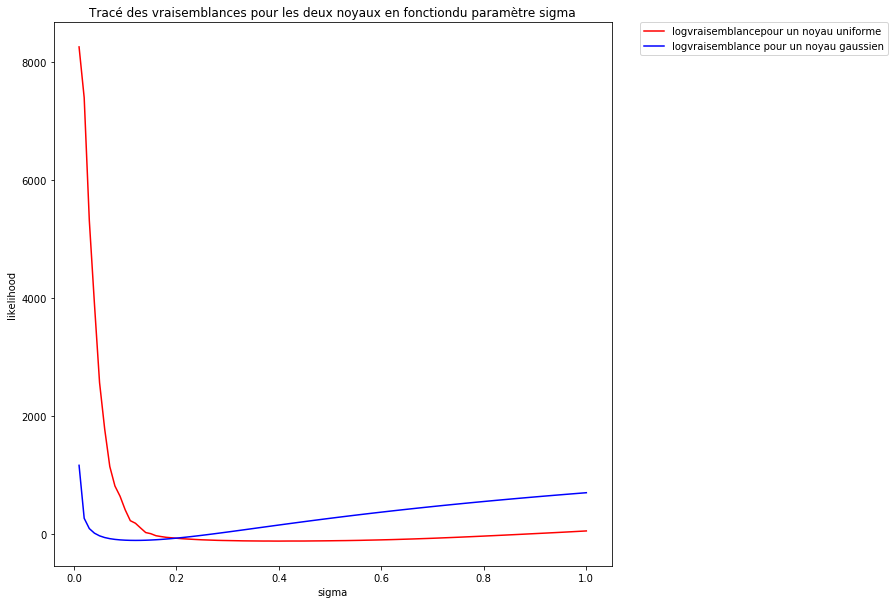

In [13]:
likelihood_estimator(geo_data[:,:2], geo_data[:threshold,-1], sigma, gaussian)
compare_kernel(geo_data[:,:2], geo_data[:threshold,-1])

En implémentant la log-vraisemblance (inverse avec un signe moins), nous remarquons que celle-ci possède un minimum (donc la vraisemblance admet un maximum) qui n'est autre que l'estimateur du maximum de vraisemblance de la fenêtre de Parzen, appris sur des données pondérées entre apprentissage et entraînement.

Par suite, pour un noyau gaussien, nous obtenons un estimateur en $\sigma_{gaussian}1 = 0.12$ qui est plus faible que le coefficient de bande passante pour un noyau uniforme dont la vraisemblance est plus étirée en fonction de sigma et possède un optimum en $\sigma_{uniforme} = 0.4$. 

### Estimateur de Nadayara-Watson et K plus proches voisins

In [14]:
def take_matrix(H):
    n, m = H.shape
    M = np.zeros((n, m))
    for k in range(1, m):
        M[:, k] = np.array(H[:,k-1]) - np.array(H[:, k]) 
    for i in range(n):
        for j in range(m):
            if M[i, j] < 0:
                M[i, j] = 0
            
    return M

take = take_matrix(histo)

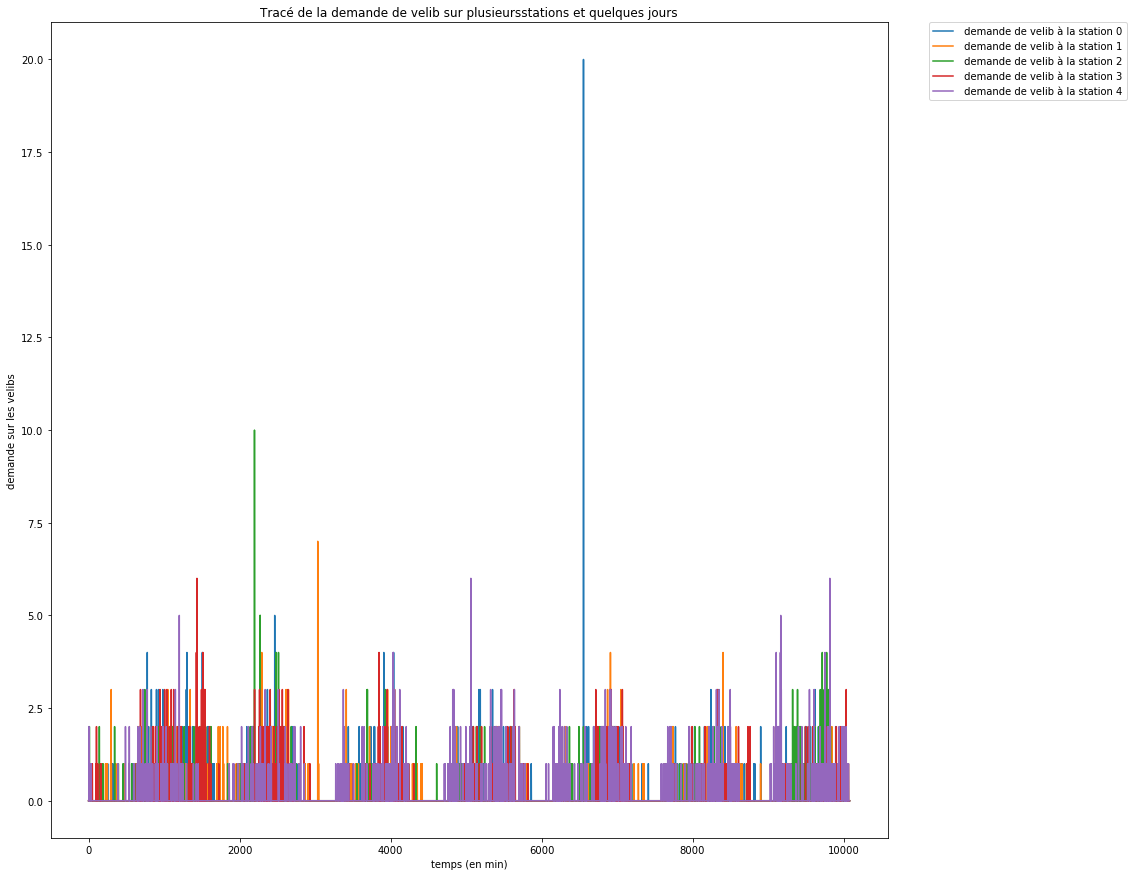

In [15]:
def demand_velib(T, nb_stations, nb_days):
    plt.figure(figsize=(15, 15))
    X = np.arange(nb_days*1440)
    for i in range(nb_stations):
        Y = np.array([T[i, k] for k in range(1440*nb_days)])
        plt.plot(X, Y, label=' demande de velib à la station '+str(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('temps (en min)')
    plt.ylabel('demande sur les velibs')
    plt.title("Tracé de la demande de velib sur plusieurs"+\
              "stations et quelques jours")
    plt.draw()
    plt.show()


demand_velib(take, 5, 7)

#### Q 2.8

On remarque qu'il n'y a pas vraiment de différence entre les stations bien que le pic de la demande sur certaines stations (surement plus convoitées que d'autres) est plus important, toutes gardent une moyenne en temps d'environ $1500$ minutes. En traçant la demande en fonction du pas de temps compté en minute, on remarque que la courbe de la demande correspond à une gaussienne centrée en $\mu = 958$ (minutes) avec un écart type assez faible.
Ceci démontre une réelle divergence entre les jours ouverts et les week-ends notamment, qui rencontrent une plus grande densité plus spécialement en fin de journée. Les gens ont donc tendance à emprunter un velib plus souvent le week-end qu'en milieu de semaine.

On pose les hypothèses de régularité suivantes :
La demande sur les velibs est la même entre le lundi et le jeudi, entre le mardi et le vendredi puis assez proche entre le samedi et le dimanche.

On considère pou la suite que la fonction de demande soit assez lisse qu'on puisse l'approcher avec un estimateur de type Nadayara-Watson par un noyau gaussien par exemple.


In [16]:
# Question 2.9
numberStation = 6
day = 2

def nadayara_watson(x, data, y, sigma, kernel):
    K = kernel(x, data, sigma)
    return (K.T.dot(y)) / np.sum(K)

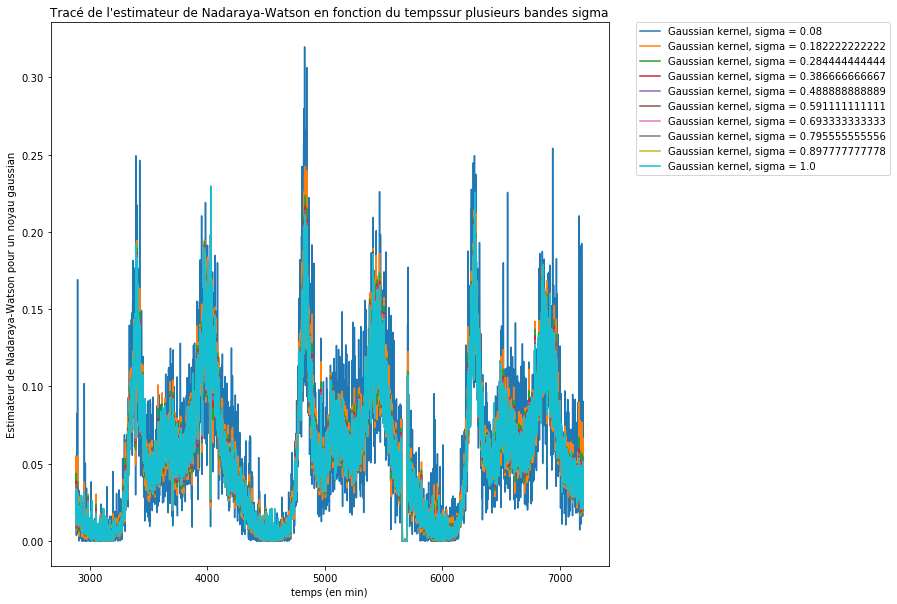

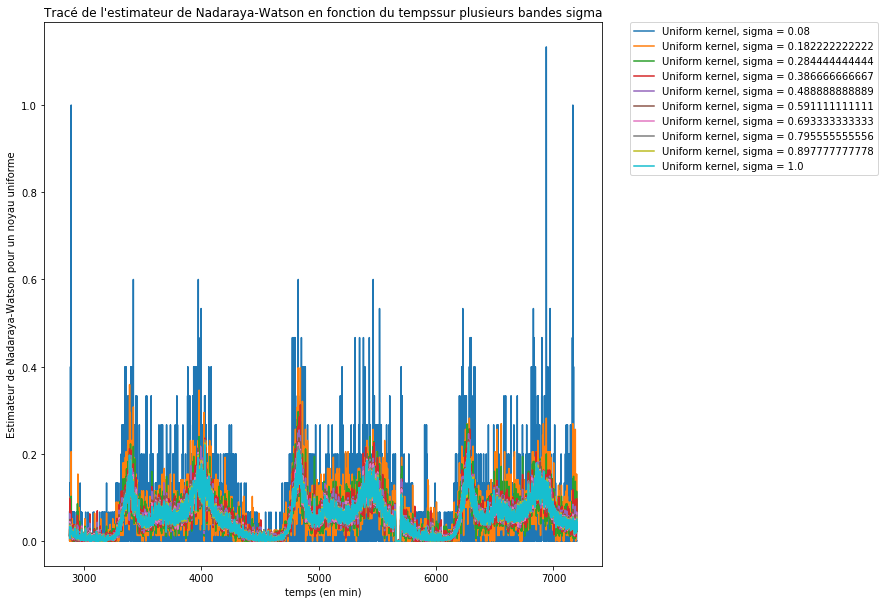

In [17]:
def NWestimator_evolution(numberStation, day, nb_days, data):
    plt.figure(figsize=(10, 10))
    sigma = np.linspace(0.08, 1, 10)
    for s in sigma:
        nw_gauss = nadayara_watson(data[numberStation], data, \
                                           take[:,1440*day:(day+nb_days)*1440],\
                                   s, gaussian).T
        plt.plot(np.arange(1440*day,(day+nb_days)*1440), nw_gauss, \
                 label='Gaussian kernel, sigma = '+str(s))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Estimateur de Nadaraya-Watson pour un noyau gaussian')
    plt.xlabel('temps (en min)')
    plt.title("Tracé de l'estimateur de Nadaraya-Watson en fonction du temps"+\
              "sur plusieurs bandes sigma")
    plt.draw()
    plt.show()
    plt.figure(figsize=(10, 10))
    
    for s in sigma:
        nw_uni = nadayara_watson(data[numberStation], data, \
                                           take[:,1440*day:(day+nb_days)*1440],\
                                 s, uni).T
        plt.plot(np.arange(1440*day,(day+nb_days)*1440), nw_uni, '-', \
                     label='Uniform kernel, sigma = '+str(s))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Estimateur de Nadaraya-Watson pour un noyau uniforme')
    plt.xlabel('temps (en min)')
    plt.title("Tracé de l'estimateur de Nadaraya-Watson en fonction du temps"+\
              "sur plusieurs bandes sigma")
    plt.draw()
    plt.show()
    

NWestimator_evolution(numberStation, day, 3, geo_data[:,:2])

On remarque donc que l'estimateur de Nadaraya-Watson est beaucoup plus volatile et fluctuant pour un noyau uniforme que pour un noyau gaussian. De plus, sa valeur fluctue d'autant plus que la bande passante $\sigma$ est petite.


In [18]:
# Question 2.10

def mse(yhat, y):
    y = y.reshape((y.shape[0], 1))
    yhat = yhat.T
    z = yhat - y
    
    err = (z.T).dot(z)/z.shape[0]
    if err.shape == (1,1):
        return err[0, 0]
    return err

day = 3
threshold = int(75./100. * geo_data.shape[0])
y = take[:,1440*day:1440*(day+1)]

def minimize_mse(threshold, data, numberStation, y, sigma, kernel):
    m = np.inf
    data_test = data[threshold:]
    data_train = data[:threshold]
    for station in range(len(data_test)):
        yhat = nadayara_watson(data_test[station], data_train,\
                               y[:threshold,:], sigma, kernel)
        tmp_m = mse(yhat, y[numberStation])
        if m > tmp_m:
            m = tmp_m
    return m
        

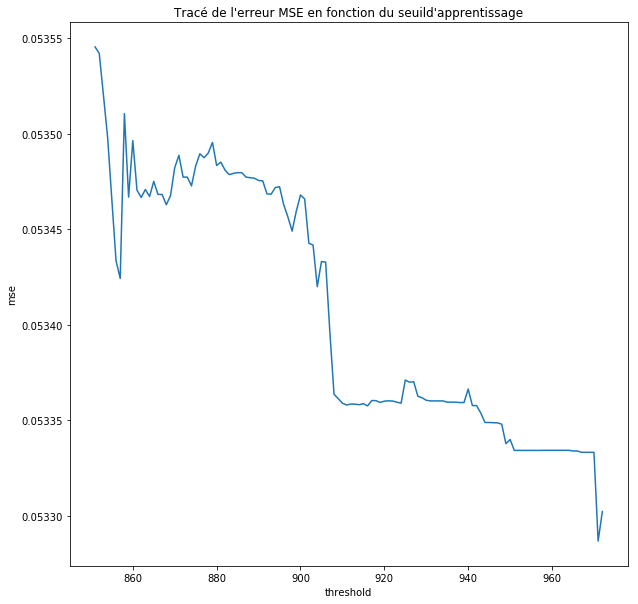

In [19]:
def find_threshold(data, numberStation, y, sigma, kernel):
    plt.figure(figsize=(10, 10))
    threshold = np.arange(int(70./100. * data.shape[0]), \
                          int(80./100. * data.shape[0]))
    list_mse = []
    for t in threshold:
        list_mse.append(minimize_mse(t, data, numberStation, \
                                     y[:t,:], sigma, kernel))
    plt.plot(threshold, list_mse)
    plt.title("Tracé de l'erreur MSE en fonction du seuil"+\
              "d'apprentissage")
    plt.xlabel('threshold')
    plt.ylabel('mse')
    plt.draw()
    plt.show()

find_threshold(geo_data[:,:2], 2, y, 0.1, gaussian)

On obtient finalement une erreur des moindres carrés assez faible de l'ordre de $10^{-2}$. 
En faisant varier la limite d'apprentissage entre les données d'entraînement et ceux d'apprentissage, on remarque que l'erreur suit la courbe tracée ci-dessus. 
Nous prendrons pour la suite une limite (threshold) d'environ $70\%$.

In [20]:
def mse_plot(data, kernel):
    threshold = int(70./100. * data.shape[0])
    data_test = data[threshold:]
    data_train = data[:threshold]
    # Tracé de la mse en fonction de sigma
    plt.figure(figsize=(7,7))
    sigma = np.linspace(0.01, 1, 100)
    err = []
    for s in sigma:
        yhat = nadayara_watson(data_test[0], data_train,\
                               take[:threshold,:1440], s, kernel)
        err.append(mse(yhat, take[0,:1440]))
    plt.plot(sigma, err)
    plt.xlabel('sigma')
    plt.title('Tracé de la MSE en fonction de la bande passante sigma')
    plt.ylabel('mse')
    plt.draw()
    plt.show()
    err = []
    
    # Tracé de la mse en fonction des stations
    plt.figure(figsize=(7,7))
    sg = 0.1
    stations = np.arange(0, 300)
    for s in stations:
        yhat = nadayara_watson(data_test[s], data_train, \
                               take[:threshold,:1440], sg, kernel)
        err.append(mse(yhat, take[s,:1440]))
    plt.plot(stations, err)
    plt.xlabel('stations')
    plt.ylabel('mse')
    plt.title('Tracé de la MSE en fonction des stations')
    plt.draw()
    plt.show()
    err = []
    
    # Tracé de la mse en fonction des jours
    plt.figure(figsize=(7,7))
    days = np.arange(0, 28)
    for d in days:
        yhat = nadayara_watson(data_test[0], data_train, \
                                   take[:threshold,1440*d:1440*(d+1)], sg, kernel)
        err.append(mse(yhat, take[0, 1440*d:1440*(d+1)]))
    plt.plot(days, err)
    plt.xlabel('days')
    plt.ylabel('mse')
    plt.title('Tracé de la MSE en fonction des jours')
    plt.draw()
    plt.show()

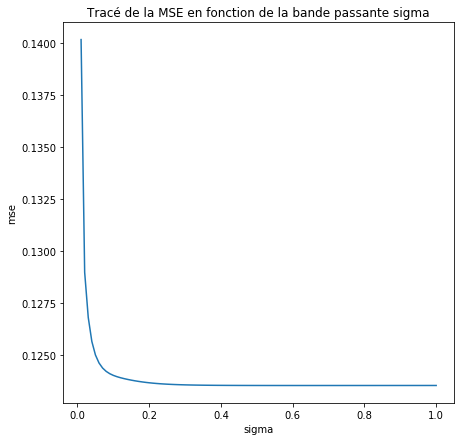

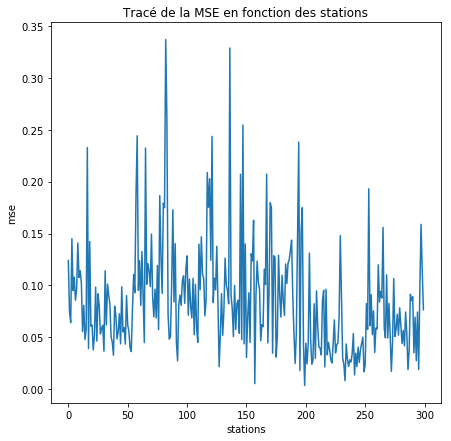

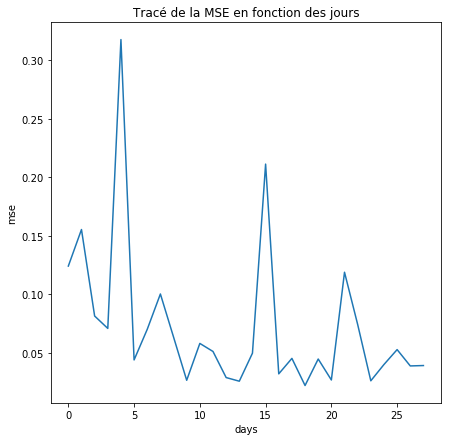

In [21]:
mse_plot(geo_data[:,:2], gaussian)

On remarque que l'erreur des moindres carrés est en forte décroissance par rapport à $\sigma$. 
En effet, à partir d'un $\sigma$ de $0.15$ environ, l'erreur des moindres carrés est assez faible.

De plus, on voit que l'erreur fluctue fortement entre les stations. Mais globalement, la courbe est assez stable autour d'une moyenne d'environ $0.1$ pour l'erreur MSE.

Enfin, le tracé de l'erreur par rapport aux $28$ jours montre que celle ci décroit au fil du temps et qu'il existe certains jours où le pic d'erreur est assez fort comme par exemple pour le $4$ ième jour.

In [22]:
# Question 2.11

t = 1440
knn = KNeighborsClassifier(7)
knn.fit(geo_data[:threshold,:2], take[:threshold,t]) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')